In [63]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import MySQLdb as mdb
import datetime
from matplotlib.dates import YEARLY, MONTHLY, DateFormatter, rrulewrapper, RRuleLocator, drange
import matplotlib.dates as mdates
from Levenshtein import ratio

import sys 
sys.path.append('..')
from algo import generate_replay_sequence, generate_replay_sequence, generateHeader, compute_similarity_fingerprint
from utils import get_fingerprints_experiments, get_consistent_ids
from fingerprint import Fingerprint

In [71]:
con = mdb.connect(host="127.0.0.1", port=3310, user="root", passwd="bdd", db="canvas_fp_project")
cur = con.cursor(mdb.cursors.DictCursor)

In [72]:
old_attributes = Fingerprint.INFO_ATTRIBUTES + Fingerprint.HTTP_ATTRIBUTES + \
                     Fingerprint.JAVASCRIPT_ATTRIBUTES + Fingerprint.FLASH_ATTRIBUTES # used without ip to generate stats


nb_min_fingerprints = 6

attributes = ["acceptHttp", "languageHttp", "userAgentHttp", "connectionHttp", "encodingHttp", "cookiesJS",
                  "resolutionJS", "timezoneJS", "pluginsJS", "sessionJS", "dntJS", "canvasJSHashed",
                  "localJS", "platformJS", "fontsFlash", "vendorWebGLJS", "rendererWebGLJS"]

print("start fetching fingerprints")
fingerprint_dataset = get_fingerprints_experiments(cur, nb_min_fingerprints,
                                                   old_attributes, "../data/consistent_extension_ids.csv")
print("Finish fetching fingerprints")

start fetching fingerprints
Finish fetching fingerprints


In [73]:
print("There are {:d} fingerprints".format(len(fingerprint_dataset)))
for fingerprint in fingerprint_dataset:
    counter_to_fingerprint[fingerprint.getCounter()] = fingerprint
    if fingerprint.getId() not in user_id_to_fingerprints:
        user_id_to_fingerprints[fingerprint.getId()] = [fingerprint.getCounter()]
    else:
        user_id_to_fingerprints[fingerprint.getId()].append(fingerprint.getCounter())
print("There are {:d} user ids".format(len(user_id_to_fingerprints)))

There are 122350 fingerprints
There are 2346 user ids


In [64]:
def compute_similarity_fingerprint(fp1, fp2, attributes, train_mode):
    similarity_vector = []
    flash_activated = fp1.hasFlashActivated() and fp2.hasFlashActivated()
    nb_changes = 0
    for attribute in attributes:
        if attribute == Fingerprint.ID:
            val_to_insert = (1 if fp1.belongToSameUser(fp2) else 0)
            similarity_vector.insert(0, val_to_insert)
        elif attribute == Fingerprint.CREATION_TIME:
            diff = fp1.getTimeDifference(fp2)
            similarity_vector.append(diff)
        elif attribute == Fingerprint.ENCODING_HTTP:
            similarity_vector.append(1) if fp1.hasSameEncodingHttp(fp2) else similarity_vector.append(0)
        elif attribute == Fingerprint.TIMEZONE_JS:
            similarity_vector.append(1) if fp1.hasSameTimezone(fp2) else similarity_vector.append(0)
        elif attribute == Fingerprint.PLUGINS_JS:
            sim = ratio(fp1.val_attributes[attribute], fp2.val_attributes[attribute])
            similarity_vector.append(sim)
        elif attribute == Fingerprint.RESOLUTION_JS:
            similarity_vector.append(1) if fp1.hasSameResolution(fp2) else similarity_vector.append(0)
        elif attribute == Fingerprint.CANVAS_JS_HASHED:
            similarity_vector.append(1) if fp1.hasSameCanvasJsHashed(fp2) else similarity_vector.append(0)
        elif attribute == Fingerprint.FONTS_FLASH:
            if flash_activated:
                similarity_vector.append(1)
                similarity_vector.append(1) if fp1.hasSameFonts(fp2) else similarity_vector.append(0)
            else:
                similarity_vector.append(0)
                similarity_vector.append(0)
        else:
            sim = ratio(str(fp1.val_attributes[attribute]), str(fp2.val_attributes[attribute]))
            similarity_vector.append(sim)

        if fp1.val_attributes[attribute] != fp2.val_attributes[attribute]:
            nb_changes += 1
            if nb_changes > 5 and not train_mode:
                return None, None

    similarity_vector.append(nb_changes)

    return np.asarray(similarity_vector[1:]), np.asarray(similarity_vector[0])


In [77]:
not_to_test = set([Fingerprint.PLATFORM_FLASH,
                           Fingerprint.PLATFORM_INCONSISTENCY,
                           Fingerprint.PLATFORM_JS,
                           Fingerprint.PLUGINS_JS_HASHED,
                           Fingerprint.SESSION_JS,
                           Fingerprint.IE_DATA_JS,
                           Fingerprint.ADDRESS_HTTP,
                           Fingerprint.BROWSER_FAMILY,
                           Fingerprint.COOKIES_JS,
                           Fingerprint.DNT_JS,
                           Fingerprint.END_TIME,
                           Fingerprint.FONTS_FLASH_HASHED,
                           Fingerprint.GLOBAL_BROWSER_VERSION,
                           Fingerprint.LANGUAGE_FLASH,
                           Fingerprint.LANGUAGE_INCONSISTENCY,
                           Fingerprint.LOCAL_JS,
                           Fingerprint.MINOR_BROWSER_VERSION,
                           Fingerprint.MAJOR_BROWSER_VERSION,
                           Fingerprint.NB_FONTS,
                           Fingerprint.NB_PLUGINS,
                           Fingerprint.COUNTER,
                           Fingerprint.OS,
                           Fingerprint.HOST_HTTP,
                           Fingerprint.ACCEPT_HTTP,
                           Fingerprint.CONNECTION_HTTP,
                           Fingerprint.ENCODING_HTTP,
                           Fingerprint.RESOLUTION_FLASH,
                           # Fingerprint.TIMEZONE_JS,
                           Fingerprint.VENDOR,
                           # Fingerprint.RENDERER
                           ])

att_ml = set(fingerprint_dataset[0].val_attributes.keys())
att_ml = sorted([x for x in att_ml if x not in not_to_test])
x_row, y_row = compute_similarity_fingerprint(fingerprint_dataset[1000], fingerprint_dataset[1500], att_ml,
                                                                      train_mode=True)
print(len(x_row))
print(len(att_ml))
print(att_ml)
print(generateHeader(att_ml))

11
10
['canvasJSHashed', 'creationDate', 'fontsFlash', 'id', 'languageHttp', 'pluginsJS', 'rendererWebGLJS', 'resolutionJS', 'timezoneJS', 'userAgentHttp']
['canvasJSHashed', 'creationDate', 'hasFlash', 'sameFonts', 'languageHttp', 'simPlugs', 'rendererWebGLJS', 'resolutionJS', 'timezoneJS', 'userAgentHttp', 'nbChange']


In [4]:
## Compute transitions

counter_to_fingerprint = dict()
user_id_to_fingerprints = dict()
for fingerprint in fingerprint_dataset:
    counter_to_fingerprint[fingerprint.getCounter()] = fingerprint
    if fingerprint.getId() not in user_id_to_fingerprints:
        user_id_to_fingerprints[fingerprint.getId()] = [fingerprint.getCounter()]
    else:
        user_id_to_fingerprints[fingerprint.getId()].append(fingerprint.getCounter())


# real analysis starts here
# for each user id, we look which attributes evolve between 2 fingerprints
cpt = 0
attribute_to_nb_change = dict()
attribute_to_time_constant = dict()
nb_transitions = 0
user_id_to_nb_transitions = dict()
user_id_to_exp_duration = dict()
for user_id in user_id_to_fingerprints:
    cpt += 1
    if len(user_id_to_fingerprints[user_id]) > nb_min_fingerprints:
        previous_counter = None
        user_id_to_nb_transitions[user_id] = 0
        first_fp = counter_to_fingerprint[user_id_to_fingerprints[user_id][0]]
        last_fp = counter_to_fingerprint[user_id_to_fingerprints[user_id][-1]]
        user_id_to_exp_duration[user_id] = last_fp.val_attributes["creationDate"] - first_fp.val_attributes["creationDate"]
        for counter in user_id_to_fingerprints[user_id]:
            fingerprint = counter_to_fingerprint[counter]                    
            if previous_counter is not None:
                previous_fingerprint = counter_to_fingerprint[previous_counter]
                has_changed = False
                for attribute in attributes:
                    if attribute not in attribute_to_nb_change:
                        attribute_to_nb_change[attribute] = 0
                        attribute_to_time_constant[attribute] = datetime.timedelta(0, 0)
                        
#                     if "lash" in attribute:
#                         if previous_fingerprint.hasFlashActivated() and \
#                            fingerprint.hasFlashActivated() and \
#                            fingerprint.val_attributes[attribute] != \
#                            previous_fingerprint.val_attributes[attribute]:
#                             diff_att = True
#                             attribute_to_nb_change[attribute] += 1
#                             has_changed = True
#                         else:
#                             attribute_to_time_constant[attribute] += fingerprint.val_attributes["creationDate"] - previous_fingerprint.val_attributes["creationDate"] 
                
#                     else:
                    if fingerprint.val_attributes[attribute] != previous_fingerprint.val_attributes[attribute]:
                        diff_att = True
                        attribute_to_nb_change[attribute] += 1
                        has_changed = True
                    else:
                        attribute_to_time_constant[attribute] += fingerprint.val_attributes["creationDate"] - previous_fingerprint.val_attributes["creationDate"] 
                if has_changed:
                    nb_transitions += 1
                    user_id_to_nb_transitions[user_id] += 1

            previous_counter = counter

print("Results:")
#     print(attribute_to_time_constant)
print("Number of transitions: %d" % nb_transitions)

transitions_per_time = []

for user_id in user_id_to_nb_transitions:
    try:
        change_ratio = user_id_to_nb_transitions[user_id]/(user_id_to_exp_duration[user_id].total_seconds()/(60.0*60*24))
        days_before_change = 1.0/change_ratio
        transitions_per_time.append(days_before_change)
    except:
        pass

p = []
p_tmp = 0
for i in range(0, len(transitions_per_time)):
    p.append(p_tmp)
    p_tmp += 1.0/len(transitions_per_time)

transitions_per_time.sort(reverse=False)
print(transitions_per_time[len(transitions_per_time)//2])

Results:
Number of transitions: 94540
5.203231292517007


2346
57.35% of the fingerprints change in less than one day
22.61% of the user fingerprints change in less than two day
29.69% of the user fingerprints have no changes after 10 days
90th percentile over all fingerints; 9.79
95th percentile over all fingerints; 18.08


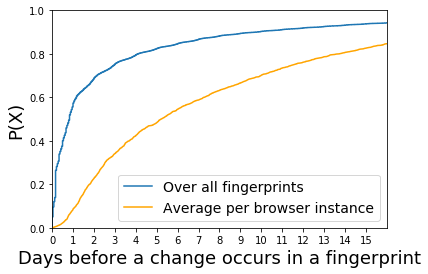

In [34]:

# cdf change over time
attributes = ["acceptHttp", "languageHttp", "userAgentHttp", "connectionHttp", "encodingHttp", "cookiesJS",
          "resolutionJS", "timezoneJS", "pluginsJS", "sessionJS", "dntJS", "canvasJSHashed",
          "localJS", "platformJS", "fontsFlash", "vendorWebGLJS", "rendererWebGLJS"]

user_id_to_fps = dict()
for fp in fingerprint_dataset:
    if fp.getId() not in user_id_to_fps:
        user_id_to_fps[fp.getId()] = []
    user_id_to_fps[fp.getId()].append(fp)

print(len(user_id_to_fps))
time_changes = list()
alreadySeen = dict()
cpt = 0
for user_id in user_id_to_fps:
    previous_fp = None
    for fp in user_id_to_fps[user_id]:
        if previous_fp is not None:
            diff_att = False
            for attribute in attributes:
                if fp.val_attributes[attribute] != previous_fp.val_attributes[attribute]:
#                     if "lash" in attribute:
#                         if previous_fp.hasFlashActivated() and \
#                            fp.hasFlashActivated() and \
#                            fp.val_attributes[attribute] != \
#                            previous_fp.val_attributes[attribute]:
#                             diff_att = True
#                             break

#                     else:
                    diff_att = True
                    break

            if diff_att:
                t1 = previous_fp.val_attributes["creationDate"]
                t2 = fp.val_attributes["creationDate"]
                diff = t2 - t1
                diffdays = diff.days + diff.seconds / (3600.0 * 24)
                time_changes.append(diffdays)

        if previous_fp is None or diff_att:
            previous_fp = fp

time_changes.sort()

    
p1 = 1. * np.arange(len(transitions_per_time)) / (len(transitions_per_time) - 1)
p2 = 1. * np.arange(len(time_changes)) / (len(time_changes) - 1)

for idx, v in enumerate(time_changes):
    if v > 1:
        print("{:.2f}% of the fingerprints change in less than one day".format(100*p2[idx]))
        break
        
for idx, v in enumerate(transitions_per_time):
    if v > 2:
        print("{:.2f}% of the user fingerprints change in less than two day".format(100*p1[idx]))
        break
        
for idx, v in enumerate(transitions_per_time):
    if v > 10:
        print("{:.2f}% of the user fingerprints have no changes after 10 days".format(100 - 100*p1[idx]))
        break
    
print("90th percentile over all fingerints; {:.2f}".format(np.percentile(time_changes, 90)))
print("95th percentile over all fingerints; {:.2f}".format(np.percentile(time_changes, 95)))
axes = plt.gca()
# l1, = plt.plot(x[0:100], y[0:100], label="Over all fingerprints")
l1, = plt.plot(time_changes, p2, label="Over all fingerprints")
l2, = plt.plot(transitions_per_time, p1, color="orange", label="Average per browser instance")

with open('./time_changes.csv', "w+") as f:
    f.write('time_change,p\n')
    for idx in range(len(time_changes)):
        f.write("{:f},{:f}\n".format(time_changes[idx], p2[idx]))
        
with open('./transitions_per_time.csv', "w+") as f:
    f.write('transitions_per_time,p\n')
    for idx in range(len(transitions_per_time)):
        f.write("{:f},{:f}\n".format(transitions_per_time[idx], p1[idx]))

plt.legend(handles=[l1, l2], loc=0, fontsize=14)
plt.xlim([0, 16])
axes.xaxis.set_ticks(range(0, 16, 1))
plt.ylim([0, 1])
plt.xlabel('Days before a change occurs in a fingerprint', fontsize=18)
plt.ylabel('P(X)', fontsize=18) # TODO replace by fraction of fingerprints
plt.savefig('./proportion_fp_change_time.pdf')
plt.show()

1.0
Num fingerprints with more than 5 users: 20


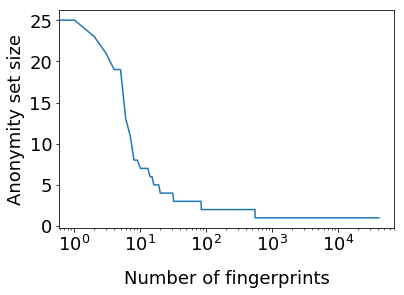

In [36]:
def compute_ano_set(fingerprint_dataset):
    # Compute fingerprint anonymity set

    attributes = ["id", "acceptHttp", "languageHttp", "userAgentHttp", "connectionHttp", "encodingHttp", "cookiesJS",
                      "resolutionJS", "timezoneJS", "pluginsJS", "sessionJS", "dntJS", "canvasJSHashed",
                      "localJS", "platformJS", "fontsFlashHashed"]
    
    fp_set = []

    unique_values = 0.0
    attribute_to_ids = dict()

    cpt = 0.0
    for fp in fingerprint_dataset:
        cpt += 1.0
        sFp = ""
        for att in attributes:
            if att != "counter" and att != "id":
#                 print(att)
                v = str(fp.val_attributes[att])
                sFp += v

        try:
            attribute_to_ids[sFp].add(fp.val_attributes["id"])
        except:
            attribute_to_ids[sFp] = set()
            attribute_to_ids[sFp].add(fp.val_attributes["id"])

    y = []
    x = []
    for val_attribute in attribute_to_ids:
        attribute_to_ids[val_attribute] = len(attribute_to_ids[val_attribute])

    sorted_dic = sorted(attribute_to_ids.items(), key=lambda x: x[1], reverse=True)

    cpt = 0.0

    limit = 0.99 * 31628
    nb_fps = 0
    found_percentile = False
#     print(len(sorted_dic))
    for k in sorted_dic:
        x.append(cpt)
        y.append(k[1])
        cpt += 1.0
        nb_fps += k[1]

#         if not found_percentile and nb_fps > limit:
#             print("Percentile: %d " % k[1])
#             found_percentile = True

    print(np.percentile(y, 95))
    t = sum([1 if num > 4 else 0 for num in y])
    print("Num fingerprints with more than 5 users: {:d}".format(t))
    
    with open("./anonymity_set.csv", "w+") as f:
        f.write("x,y\n")
        for idx in range(len(x)):
            f.write("{:f},{:f}\n".format(x[idx], y[idx]))
            
    plt.plot(x, y)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel('Number of fingerprints', fontsize=18, labelpad=15)
    plt.ylabel('Anonymity set size', fontsize=18)
    plt.xscale('log')
    plt.savefig('./anonymity_set.pdf', bbox_inches="tight")
    plt.show()
    
compute_ano_set(fingerprint_dataset)

In [9]:
def new_compute_attributes_evolution(cur, fingerprint_dataset):
    attributes = Fingerprint.INFO_ATTRIBUTES + Fingerprint.HTTP_WITHOUT_IP + \
                         Fingerprint.JAVASCRIPT_ATTRIBUTES + Fingerprint.FLASH_ATTRIBUTES
    nb_transitions = 0

    counter_to_fingerprint = dict()
    user_id_to_fingerprints = dict()
    for fingerprint in fingerprint_dataset:
        counter_to_fingerprint[fingerprint.getCounter()] = fingerprint
        if fingerprint.getId() not in user_id_to_fingerprints:
            user_id_to_fingerprints[fingerprint.getId()] = [fingerprint.getCounter()]
        else:
            user_id_to_fingerprints[fingerprint.getId()].append(fingerprint.getCounter())
    
    
    # real analysis starts here
    # for each user id, we look which attributes evolve between 2 fingerprints
    cpt = 0
    attribute_to_nb_change = dict()
    nb_changes_per_day = dict()
    for user_id in user_id_to_fingerprints:
        cpt += 1
        # we need at least 2 fingerprints to perform the analysis
        if len(user_id_to_fingerprints[user_id]) >= 2:
            attribute_to_nb_change = dict()
            previous_counter = None
            first_fp = counter_to_fingerprint[user_id_to_fingerprints[user_id][0]]
            last_fp = counter_to_fingerprint[user_id_to_fingerprints[user_id][-1]]
            exp_duration = (last_fp.val_attributes["creationDate"] - first_fp.val_attributes["creationDate"]).total_seconds()/(60*60*24.0)
            if exp_duration == 0:
                continue
            for counter in user_id_to_fingerprints[user_id]:
                fingerprint = counter_to_fingerprint[counter]                    
                if previous_counter is not None:
                    previous_fingerprint = counter_to_fingerprint[previous_counter]
                    has_changed = False
                    for attribute in fingerprint.val_attributes:
                        if attribute not in attribute_to_nb_change:
                            attribute_to_nb_change[attribute] = 0

                        # need to make special cases after for flash
                        if "lash" in attribute:
                            if previous_fingerprint.hasFlashActivated() and \
                               fingerprint.hasFlashActivated() and \
                               fingerprint.val_attributes[attribute] != \
                               previous_fingerprint.val_attributes[attribute]:
                                attribute_to_nb_change[attribute] += 1
                                has_changed = True
                                    
                        elif attribute != "counter" and \
                           attribute != "creationDate" and attribute != "endDate" and \
                           fingerprint.val_attributes[attribute] != \
                           previous_fingerprint.val_attributes[attribute]:
                           attribute_to_nb_change[attribute] += 1
                           has_changed = True
                    if has_changed:
                        nb_transitions += 1

                previous_counter = counter
            for attribute in attributes:
                try:
                    nb_changes_per_day[attribute].append(attribute_to_nb_change[attribute]/exp_duration)
                except:
                    nb_changes_per_day[attribute] = [attribute_to_nb_change[attribute]/exp_duration]
    
    print("Results:")
    for attribute in nb_changes_per_day:
        print(attribute)
        print(np.percentile(nb_changes_per_day[attribute], 50), 1.0/(np.percentile(nb_changes_per_day[attribute], 50) +0.0000001))
        print(np.percentile(nb_changes_per_day[attribute], 90), 1.0/(np.percentile(nb_changes_per_day[attribute], 90) +0.0000001))
        print(np.percentile(nb_changes_per_day[attribute], 95), 1.0/(np.percentile(nb_changes_per_day[attribute], 95) +0.0000001))
        print(np.mean(nb_changes_per_day[attribute]), 1.0/(np.mean(nb_changes_per_day[attribute]) +0.0000001))
        print()
    
new_compute_attributes_evolution(cur, fingerprint_dataset)

Results:
id
0.0 10000000.0
0.0 10000000.0
0.0 10000000.0
0.0 10000000.0

counter
0.0 10000000.0
0.0 10000000.0
0.0 10000000.0
0.0 10000000.0

creationDate
0.0 10000000.0
0.0 10000000.0
0.0 10000000.0
0.0 10000000.0

endDate
0.0 10000000.0
0.0 10000000.0
0.0 10000000.0
0.0 10000000.0

acceptHttp
0.0 10000000.0
0.005139874062700999 194.55351093240947
0.007779084849033273 128.54817302924369
0.001738094623008134 575.3095693446523

languageHttp
0.0 10000000.0
0.00642669539878095 155.59854296741457
0.017981787574725322 55.61151441106568
0.033891994536066644 29.50540572037644

userAgentHttp
0.031331592689295036 31.91656479963068
0.08570466829114429 11.667962237561152
0.13530662098283686 7.390615874335216
0.08282720389440286 12.073313424217059

orderHttp
0.0026942074539739558 371.1528907085399
0.03026290950322095 33.04364028612449
0.07183483778711236 13.920802757059063
0.026752072252210945 37.38014208985794

connectionHttp
0.0 10000000.0
0.0 10000000.0
0.0 10000000.0
0.0 10000000.0

encodingHt

['07/2015', '8/2015', '9/2015', '10/2015', '11/2015', '12/2015', '1/2016', '2/2016', '3/2016', '4/2016', '5/2016', '6/2016', '7/2016', '8/2016', '9/2016', '10/2016', '11/2016', '12/2016', '1/2017', '2/2017', '3/2017', '4/2017', '5/2017', '6/2017', '7/2017', '8/2017', '9/2017', '10/2017'] 28
[0, 105, 186, 739, 1203, 1723, 2918, 3673, 3938, 2266, 3372, 4566, 4546, 4068, 5025, 6005, 5882, 6539, 8120, 8519, 6191, 6111, 6456, 6017, 5885, 8563, 8239, 1495] 28


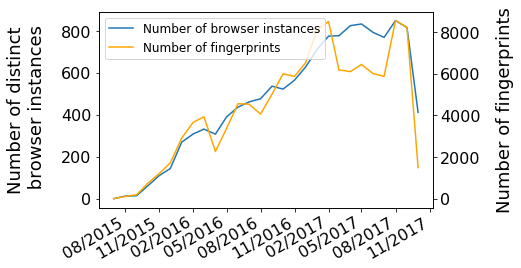

In [38]:
def plot_cdf_users(cur, fingerprint_dataset):
    # compute cumulative number of users as well as cumulated number of fingerprints
    # take into account the fact that some users are present only once in the db
    current_month = None
    users_seen_period = set()
    dates_list = []
    nb_users_list = [0]
    nb_fps_list = [0]
    dates = ["07/2015"]
    dates_list.append(datetime.date(year=2015, month=7,day=1))
    
    # nb of distinct users which had a fp collected on the given period
    # period of 1 month
    for fp in fingerprint_dataset:
        if current_month is None:
            current_month = fp.val_attributes["creationDate"].month
            current_year = fp.val_attributes["creationDate"].year
            dates_list.append(datetime.date(year=current_year, month=current_month,day=1))
            nb_users_list.append(0)
            nb_fps_list.append(0)
            dates.append(str(current_month)+"/"+str(current_year))
        
        if current_month == fp.val_attributes["creationDate"].month: # and current year ?
            nb_fps_list[-1] += 1
            if fp.getId() not in users_seen_period:
                users_seen_period.add(fp.getId())
                nb_users_list[len(nb_users_list)-1] += 1
        else:
            users_seen_period = set()
            current_month = fp.val_attributes["creationDate"].month
            current_year = fp.val_attributes["creationDate"].year
            dates.append(str(current_month)+"/"+str(current_year))
            dates_list.append(datetime.date(year=current_year, month=current_month,day=1))
            nb_users_list.append(1)
            nb_fps_list.append(1)
    
    print(dates, len(dates))
    print(nb_fps_list, len(nb_fps_list))
    
    with open("cdf_users.csv", "w+") as f:
        f.write("date,num_users\n")
        for idx in range(len(nb_users_list)):
            f.write("{},{:d}\n".format(str(dates_list[idx]), nb_users_list[idx]))
            
    with open("cdf_fingerprints.csv", "w+") as f:
        f.write("date,num_fps\n")
        for idx in range(len(nb_fps_list)):
            f.write("{},{:d}\n".format(str(dates_list[idx]), nb_fps_list[idx]))
            
    # probably remove this
#     nb_users_list.pop()
#     nb_fps_list.pop()
#     dates_list.pop()
#     nb_users_list[-1] = 650
#     nb_fps_list[-1] = 3700
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
#     ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
    
    ax1.set_ylabel('Number of distinct\n browser instances', fontsize=18, labelpad=15)
    ax2.set_ylabel('Number of fingerprints', fontsize=18, labelpad=15)

    line1, = ax1.plot(dates_list, nb_users_list, label="Number of browser instances")

    line2, = ax2.plot(dates_list, nb_fps_list, color="orange", label="Number of fingerprints")
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))

    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 16)
    ax2.tick_params(axis = 'both', which = 'major', labelsize = 16)


    plt.legend(handles=[line1, line2], loc=0, fontsize=12)
#     plt.plot(dates_list, nb_fps_list)
    plt.gcf().autofmt_xdate()
    plt.savefig('./cdf_users.pdf', bbox_inches = 'tight')
    plt.show()
    
plot_cdf_users(cur, fingerprint_dataset)